In [1]:
# standard imports\n",
import os
import random
import numpy as np

# work with data\n",
import pandas as pd
import h5py

#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import glob
from tqdm.auto import tqdm
from IPython.display import clear_output

# like numpy, only good + NN
import torch, torch.nn as nn
import torch.nn.functional as torch_nn_F
from torch.utils.data import DataLoader, Dataset, Subset
# import torchvision
# from torchvision import transforms
import time


# local
import utils

from scipy.linalg import block_diag


plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

# Dark plots\n",
#plt.style.use('dark_background')\n",

TIME_STEP = 1
CLASSNAME = {0: 'ballistic', 1: 'hgv', 2: 'hcm'}
CLASSTYPE = {'ballistic': 0, 'hgv': 1, 'hcm': 2}

# Prepare data
## Load and examine data

In [2]:
# Data reading function
def read_trajectories(path_to_file, look: bool = False):
    with h5py.File(path_to_file, 'r') as dset:
        for k, v in dset.attrs.items():
            print(f"{k}: {v}")

    dset = pd.HDFStore(path_to_file, 'r')
    if look:
        print(dset.info())
    return dset

## Splitting the data

In [68]:
def train_val_test_split(data, tts = (0.7, 0.1, 0.2), shuffle=False):
    '''Split data into train, validation and test sets according to `tts` tuple

    By default, tts = (train, val, test) = (0.7, 0.1, 0.2)
    '''
    assert sum(tts) == 1

    if shuffle:
        data = np.random.shuffle(data)

    h = len(data)
    train = data[:int(h * tts[0])]
    val = data[int(h * tts[0]) : int(h * np.round(tts[0] + tts[1], 4))]
    test = data[int(h * np.round(tts[0] + tts[1], 4)) : int(h * sum(tts))]

    return train, val, test

## Invertible trajectory pre-processing transform

In [197]:
class RelativeTrajectory():
    def __init__(self, df, diff=False, ref_point=30, check_point=100, config = None):
        if config == None:
            self.init0(df, diff, ref_point, check_point)
        else:
            self.init1(df, config)

    def init0(self, df, diff=False, ref_point=30, check_point=100):
    
        self.diff = diff
        self.ref_point = ref_point

        data = np.array(df.drop('t', 1))
        assert data.shape[0] >= ref_point
        
        # Remember first state
        self.start_state = data[0].copy()
        
        # Make changes relative to the start state
        data -= self.start_state

        # Scale data to kilometers
        data /= 1000

        # Rotate coordinate system
        x = utils.normalize(data[-1, :3] - data[0, :3])             # X axis along flight direction
        z = utils.orthogonal(x, data[ref_point, :3] - data[0, :3])  # Z axis along upward (from Earth)
        y = np.cross(z, x)                                          # Y is a cross product to form basis
        
        p = np.array([x, y, z])  # -> Relative CS axes in current frame
        p_prime = np.eye(3)      # -> How they should be
        self.M = utils.get_transformation_matrix(p, p_prime)[:3, :3]
                
        # Perform rotation for coordinates
        data[:, :3] = data[:, :3].dot(self.M)
        #data[:, :3] = np.absolute(data[:, :3])
        
        
        check_point = len(data)//3
        self, data = self.abs(data, check_point)
          
            
        
        # Perform rotation for velocities
        if data.shape[1]>3:
            data[:, 3:6] = data[:, 3:6].dot(self.M)

        
        ## Calculate angle of rotation: arctan(y_r / x_r), where r is ref_point
        self.theta = np.arctan(data[check_point][1] / data[check_point][0])

        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, :3] = self.rotate_Z(data[:, :3], -self.theta)


        self.first_diff_elem = None
        if diff:
            self.first_diff_elem = data[0].copy()
            data = np.diff(data, axis=0)

        self.data = data

    def init1(self, data, config):
        self.data = data
        self.ref_point = config['ref_point']
        self.diff = config['diff']
        self.start_state = config['start_state']
        self.first_diff_elem = config['first_diff_elem']
        self.M = config['M']
        self.theta = config['theta']
        self.abs = config['abs']



    def restore(self, columns, ts=1, config=None):

        assert ts > 0

        if config:
            self.set_info(config)

        # Restore diff data
        if self.diff:
            data = np.r_[np.expand_dims(self.first_diff_elem, 0), np.cumsum(self.data, axis=0)]
        else:
            data = self.data.copy()

        
        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, :3] = self.rotate_Z(data[:, :3], self.theta)


        data[:,:3] = data[:,:3] * self.abs[:3]


        # Perform rotation for coordinates
        data[:, 0:3] = data[:, 0:3].dot(np.linalg.inv(self.M))

        # Perform rotation for velocities
        if data.shape[1]>3:
          data[:, 3:6] = data[:, 3:6].dot(np.linalg.inv(self.M))

        # Scale data from km back to meters
        data *= 1000
        
        # Make changes absolute
        if data.shape[1]==3:
            data += self.start_state[:3]

        # Restore Pandas.DataFrame format
        t = np.arange(0, data.shape[0], ts)
        data = np.c_[data, t]
        data = pd.DataFrame(data, columns=columns)

        return data

    @staticmethod
    def rotate_Z(data, theta):
        """Rotate data around the Z axis using matrix R"""
        
        R = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [            0,              0, 1]
        ])
        return data @ R.T

    @staticmethod
    def rotate_X(data, theta):
        """Rotate data around the X axis using matrix R"""
        
        R = np.array([
            [ 1,              0,              0],
            [ 0,  np.cos(theta), -np.sin(theta)],
            [ 0,  np.sin(theta),  np.cos(theta)]
        ])
        return data @ R

    @staticmethod
    def rotate_Y(data, theta):
        """Rotate data around the Y axis using matrix R"""
        
        R = np.array([
            [ np.cos(theta),  0, np.sin(theta)],
            [             0,  1,             0],
            [-np.sin(theta),  0, np.cos(theta)]
        ])
        return data @ R

    
    def abs(self, data, check_point):
        self.abs = np.array([1,1,1])


        if (data[check_point][2] < 0):
            self.abs[2] = -1
            data[:, 2] = self.abs[2]*(data[:, 2])

        if (data[check_point][1] < 0):
            self.abs[1] = -1
            data[:, 1] = self.abs[1]*(data[:, 1])
        
        if (data[check_point][0] < 0):
            self.abs[0] = -1
            data[:, 0] = self.abs[0]*(data[:, 0])
        return self, data
    
    @property
    def info(self):
        return {
            'ref_point' : self.ref_point,
            'diff' : self.diff,
            'start_state' : self.start_state,
            'first_diff_elem' : self.first_diff_elem,
            'M' : self.M,
            'theta' : self.theta,
            'abs': self.abs
        }
    
    
    @info.setter
    def info(self, config):
        self.ref_point = config['ref_point']
        self.diff = config['diff']
        self.start_state = config['start_state']
        self.first_diff_elem = config['first_diff_elem']
        self.M = config['M']
        self.theta = config['theta']
        self.abs = config['abs']

## Generation of datasets

In [5]:
def max_min_len_coordinate(dset, keys):
    max_size = 0
    min_size = len(np.array(dset[keys[0]])[:,0])
    for key_k in keys:
        size = len(np.array(dset[key_k])[:,0])
        if size > max_size:
            max_size = size
            max_key = key_k
        if size < min_size:
            min_size = size
            min_key = key_k
    return (max_size, min_size, max_key, min_key)

def max_coordinate(dset, keys):
    max_size = [0,0,0]
    for key_k in keys:
        x = np.absolute(np.array(dset[key_k][0])).max(axis=0)
        for i in range(3):
            if x[i] > max_size[i]:
                max_size[i] = x[i]
    return max_size

In [170]:
def get_strided_data_clust(dset, keys, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, verbose=False):
    '''Return list with parts of trajectories and their residuals.
    
    Arguments:
        dset -- h5py Data set with trajectory data
        keys -- keys for extracting data from `dset`
        
    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude
        
        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]
        
        gt_size -- how many trajectory points are to be observed
        horizon -- how many trajectory points are to be predicted
        step -- (default: 1) 
                if 1, every row from the `dset` will be processed,
                if >1, some rows will be skipped accordingly.
        diff -- (default: False) toggle extract differentiated relative trajectories
    '''
    
    assert variables in [3, 6, 7]
    
    # Create list with parts of trajectories,
    # each element has (gt_size+horizon) trajectory points
    data_seqs = []
    
    # Set of configs for each trajectory. 
    configs = {}
    
    # List of trajectory indices 
    # (to which trajectory this traj_elem belongs to)
    traj_ids = []
    
    # Collect trajectories, preprocess and 
    # split them into trajectory parts
    for k in tqdm(range(len(keys)), disable=1-verbose, desc='Collecting strided data'):
        # Get relative trajectory from the dataset
        rt = RelativeTrajectory(dset[keys[k]], diff=diff)
        configs[k] = rt.info  # save for future restoration

        # Collect list of trajectory parts from `rt` 
        # using time window [gt_size + horizon] and time shift `step`
        for i in range(1 + (rt.data.shape[0] - gt_size - horizon) // step):
            data_seqs.append([rt.data[i*step : i*step + gt_size + horizon, :variables]])
            traj_ids.append(k)
    
    data_norm_factor = np.array(max_coordinate(data_seqs, range(len(data_seqs)))) / 100
    #data_seqs = np.array(data_seqs) / data_norm_factor
    data_seqs_noise = np.random.normal(data_seqs, random.randint(1,2)/2)
    
    #data_seqs = np.array(data_seqs) / data_norm_factor
    #data_seqs_noise = data_seqs_noise / data_norm_factor
    
    
    # Collect all data seqs into one huge dataset 
    # of shape [? , gt_size + horizon, variables]
    data_seqs_all = np.stack(data_seqs).squeeze()
    data_seqs_all_noise = np.stack(data_seqs_noise).squeeze()
    traj_ids_all = np.stack(traj_ids)

    # Calculate mean and std over all data
    data_mean = data_seqs_all.mean((0, 1))
    data_std = data_seqs_all.std((0, 1))
    res_mean = np.zeros(variables)
    res_std = np.ones(variables)
    
    if residuals:
        # Compute and add columns with residuals
        # note that the first row should be zeros
        # (if we have 8 measurements, we only can have 7 residuals)
        res = np.concatenate((
            np.zeros((data_seqs_all.shape[0], 1, variables)),
            data_seqs_all[:, 1:, :] - data_seqs_all[:, :-1, :]
        ), 1)
    
        res_mean = res[:, 1:].mean((0, 1))
        res_std = res[:, 1:].std((0, 1))
    
        data_seqs_all = np.concatenate((data_seqs_all, res), 2)
    
    stats = {
        'data_mean': data_mean,
        'data_std': data_std,
        'res_mean': res_mean,
        'res_std': res_std, 
        'data_norm_factor': data_norm_factor
    }
    
    if verbose:
        with np.printoptions(precision=3):
            print(f'Total trajectory parts: {data_seqs_all.shape[0]}')
            print(f'Each: {gt_size} observed + {horizon} horizon = {gt_size+horizon} points in total')
            if residuals:
                print(f'Each point contains {int(data_seqs_all.shape[-1]/2)} variables and {int(data_seqs_all.shape[-1]/2)} residuals')
            else:
                print(f'Each point contains {data_seqs_all.shape[-1]} variables')

            print('Data mean:', stats['data_mean'],
                  'Data std:', stats['data_std'], 
                  'Data normalization factor', stats['data_norm_factor'],
                  sep='\n')
            if residuals:
                print('Residuals mean:', stats['res_mean'],
                      'Residuals std:', stats['res_std'], 
                      sep='\n')
    return (
        data_seqs_all.squeeze()[:, :gt_size], # src sequences
        data_seqs_all.squeeze()[:, gt_size:], # tgt sequences
        data_seqs_all_noise.squeeze()[:, :gt_size], # data_noise sequences
        configs,
        stats,
        traj_ids_all
    )

In [7]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, data, name, variables=3, configs=None, stats=None):
        super().__init__()
    
        self.data = data
        self.name = name
        self.variables = variables
        self.configs = configs
        self.stats = stats
        
    def __len__(self):
        return self.data['data'].shape[0]
    
    def __getitem__(self, index):
        
        ret =  {
            'data': torch.Tensor(self.data['data'][index]),
            'tgt': torch.Tensor(self.data['tgt'][index]),
            'data_noise': torch.Tensor(self.data['data_noise'][index]),
            'traj_id': self.data['traj_ids'][index],
        }
        return ret

In [8]:
def create_dataset(dset, keys, name, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, train=True, scaler=None, verbose=False):
    """Create TrajectoryDataset for training NNs.

    Arguments:
        dset -- h5py dataset object
        keys -- list of strings: keys for extracting data from `dset`
        name -- name of the TrajectoryDataset

    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude

        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]

        gt_size -- how many points are observed (model input)
        horizon -- how many points the model tries to predict into the future
        step -- stride step for data
        diff -- toggle differentiate trajectories
        train -- this data will be used for training
        scaler -- custom scaler, so data will have zero mean and unit variance
        verbose -- toggle print info to the terminal
        
    Note:
        If `train == True`, the scaler will fit on the collected data and
        then returned as the TrajectoryDataset.scaler attribute
        
        If 'train == False', this function will look for scaler from the 
        arguments, then use it to scale collected data for evaluation.
    """
    if verbose:
        print(f"Loading dataset in {'train' if train else 'evaluation'} mode...")

    inp, out, inp_noise, configs, stats, traj_ids = get_strided_data_clust(
        dset, keys, variables, residuals, gt_size, horizon, step, diff, verbose)

    data = {
        'data': inp,
        'tgt': out,
        'data_noise': inp_noise,  
        'traj_ids': traj_ids
    }

    return TrajectoryDataset(data, name, variables, configs, stats)

## Recurrent Module

In [9]:
# Our recurrent Module
class ModuleRNN(nn.Module):
    """
    Implement the scheme above as torch module
    torch style
    
    """
    def __init__(self, vect_dim=3, rnn_num_units=64):
        super(self.__class__,self).__init__()
        
        self.num_units = rnn_num_units
        self.vect_dim = vect_dim

#         our linear layer
        self.rnn_update = self.block(vect_dim, rnn_num_units)

        self.rnn_forget = self.block(vect_dim, rnn_num_units)
        self.rnn_save = self.block(vect_dim, rnn_num_units)
        self.rnn_data_selection = self.block(vect_dim, rnn_num_units)
        self.rnn_quick_overview = self.block(vect_dim, rnn_num_units)

        self.rnn_prediction = self.predicted_block(rnn_num_units+vect_dim, vect_dim)

        
    def forward(self, new_data, flash_memory, short_term_memory, long_term_memory, F):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        memory = torch.cat([new_data, short_term_memory], dim=-1)

        forgetfulness = torch.sigmoid(self.rnn_forget(memory)) #forgetting dataforgetting data
        conservation = torch.tanh(self.rnn_save(memory)) #the acquisition of new data
        information = torch.sigmoid(self.rnn_data_selection(memory))

        long_term_memory = (forgetfulness * long_term_memory) + (information * conservation)

        short_term_memory = torch.sigmoid(self.rnn_quick_overview(memory)) * torch.tanh(long_term_memory)
        
        with torch.no_grad():
            flash_memory = self.predict_Kalman(F, flash_memory)
            flash_memory_grad = flash_memory[:,0::3]


        predicted_data = self.rnn_prediction(torch.cat([flash_memory_grad, short_term_memory], dim=-1))

        with torch.no_grad(): 
            flash_memory[:,0::3] = predicted_data

        return predicted_data, flash_memory, short_term_memory, long_term_memory

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, dtype=torch.float32, requires_grad=True)

    def initial_state_old_data(self, batch_size):
        return torch.zeros(batch_size, self.vect_dim*3, dtype=torch.float32, requires_grad=True)

    def block(self, in_f, out_f):
        return nn.Sequential(
            self.base_block(in_f + out_f, (in_f + 2 * out_f)//2),
            self.base_block((in_f + 2 * out_f)//2, out_f)
        )


    def base_block(self, in_f, out_f):
        return nn.Sequential(
            nn.Linear(in_f, out_f),
        )

    def predicted_block(self, in_f, out_f):
        return nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_f, (in_f + out_f)//2),
            nn.Dropout(0.5),
            nn.Linear((in_f + out_f)//2, out_f),
            
        )

    def predict_Kalman(self, F, old_data):
        return torch.mm(F, old_data.transpose(0,1)).transpose(0,1)


In [11]:
'''
RNN old
without kalman
'''
# Our recurrent Module
class ModuleRNN(nn.Module):
    """
    Implement the scheme above as torch module
    torch style
    
    """
    def __init__(self, vect_dim=3, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

#         our linear layer
        self.rnn_update = self.block(vect_dim, rnn_num_units)

        self.rnn_forget = self.block(vect_dim, rnn_num_units)
        self.rnn_save = self.block(vect_dim, rnn_num_units)
        self.rnn_data_selection = self.block(vect_dim, rnn_num_units)
        self.rnn_quick_overview = self.block(vect_dim, rnn_num_units)

        
        self.rnn_prediction = self.predicted_block(rnn_num_units, vect_dim)

    def forward(self, new_data, short_term_memory, long_term_memory):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        memory = torch.cat([new_data, short_term_memory], dim=-1)

        forgetfulness = torch.sigmoid(self.rnn_forget(memory)) #forgetting dataforgetting data
        conservation = torch.tanh(self.rnn_save(memory)) #the acquisition of new data
        information = torch.sigmoid(self.rnn_data_selection(memory))

        long_term_memory = (forgetfulness * long_term_memory) + (information * conservation)

        short_term_memory = torch.sigmoid(self.rnn_quick_overview(memory)) * torch.tanh(long_term_memory)



        #compute logits for next character probs
        predicted_data = self.rnn_prediction(short_term_memory)

        return predicted_data, short_term_memory, long_term_memory

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

    def block(self, in_f, out_f):
        return nn.Sequential(
            self.base_block(in_f + out_f, (in_f + 2 * out_f)//2),
            self.base_block((in_f + 2 * out_f)//2, out_f)
        )


    def base_block(self, in_f, out_f):
        return nn.Sequential(
            nn.Linear(in_f, out_f),
        )

    def predicted_block(self, in_f, out_f):
        return nn.Sequential(
            nn.Linear(in_f, (in_f + out_f)//2),
            nn.Dropout(0.05),
            nn.Linear((in_f + out_f)//2, out_f),
            
        )

In [10]:
def preKalman(vect_dim=3, time_step = 0.25):
    F = np.array([[1., time_step, time_step**2/2],
                  [0., 1.,        time_step     ],
                  [0., 0.,        1.            ]])

    
    if vect_dim==3:
          F = block_diag(F, F, F)
    elif vect_dim==2:
          F = block_diag(F, F)

    F = torch.from_numpy(F).type(torch.float32)

    return F


## RNN Loop

In [11]:
def rnn_loop(trajectories_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, vec_dim = batch_ix.size()

    short_term_memory = trajectories_rnn.initial_state(batch_size)
    long_term_memory = trajectories_rnn.initial_state(batch_size)

    flash_memory_copy = torch.zeros(batch_size, vec_dim*3, dtype=torch.float32)
    flash_memory = trajectories_rnn.initial_state_old_data(batch_size)

    flash_memory_copy[:,0::3] = batch_ix.transpose(0,1)[0]
    flash_memory = flash_memory_copy
    predictions = []

    F = preKalman(3, 0.1)

    for new_data in batch_ix.transpose(0,1):
        prediction, flash_memory, short_term_memory, long_term_memory = trajectories_rnn(new_data, flash_memory.to(device), short_term_memory.to(device), long_term_memory.to(device), F.to(device))  # <-- here we call your one-step code
        predictions.append(prediction)

    return torch.stack(predictions, dim=1)

In [ ]:
'''
RNN old
without kalman
'''
def rnn_loop(trajectories_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, vec_dim = batch_ix.size()

    short_term_memory = trajectories_rnn.initial_state(batch_size)
    long_term_memory = trajectories_rnn.initial_state(batch_size)
    predictions = []

    for new_data in batch_ix.transpose(0,1):
        prediction, short_term_memory, long_term_memory = trajectories_rnn(new_data, short_term_memory.to(device), long_term_memory.to(device))  # <-- here we call your one-step code
        predictions.append(prediction)

    return torch.stack(predictions, dim=1)

## The training loop

In [216]:
def accuracy(x_pred, x_real, Discrepancy):
    delta = np.absolute(x_pred)-np.absolute(x_real)
    return np.sum((np.absolute(delta/x_real) <= Discrepancy) | (np.absolute(delta/x_pred) <= Discrepancy))/ x_real.size

def print_epoc(train_loss, val_loss, train_accuracy, val_accuracy, epoc, EPOC_NUM, lr, now_time, start_time):
    print(f'Epoch {epoc + 1} of {EPOC_NUM} took {now_time - start_time:.3f}s')
    
    print('      training loss:', train_loss[-1],)
    print('    validation loss:', val_loss[-1])
    print('train accuracy:', train_accuracy[-1]*1000//1/10,'%')
    print('validation accuracy:', val_accuracy[-1]*1000//1/10,'%')
    if lr!=0:
        print('changed optimizer lr:', lr)
    # print(f"\t  training loss: {train_loss[-1]:.9f}")
    # print(f"\tvalidation loss: {val_loss[-1]:.9f}")
    # print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    if len(train_loss)>5:
        plot_process(train_loss[-5:], val_loss[-5:], None, train_accuracy[-5:], val_accuracy[-5:], None)
    plot_process(train_loss, val_loss, None, train_accuracy, val_accuracy, None)
    

In [13]:
def traning_fun(trajectories_rnn, criterion, opt, train_dl, val_dl, train_loss, val_loss, train_accuracy, val_accuracy, Discrepancy, EPOC_NUM, device, draw: bool = False):

    error = 0
    retraining = 0
    

    if (draw)&(len(train_loss)>0):
        for g in opt.param_groups:
                lr =  g['lr']
        print_epoc(train_loss, val_loss, train_accuracy, val_accuracy, 0, EPOC_NUM, lr, time.time(), time.time())
    lr = 0

    for epoc in range(EPOC_NUM):

        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()

        

        if ((epoc+1)%(EPOC_NUM/4) == 0)&(EPOC_NUM > 5): 
            for g in opt.param_groups:
                g['lr'] = g['lr']/10
                lr =  g['lr']
        
        trajectories_rnn.train(True) # enable dropout / batch_norm training behavior
        for id_b, batch_total in enumerate(train_dl):
            opt.zero_grad()
            batch = batch_total['data_noise'].to(device, torch.float32)

            predictions = rnn_loop(trajectories_rnn, batch, device)

            # compute loss
            data_real = batch_total['data'].to(device, torch.float32)

            # print(predictions_logp.shape, actual_next_tokens.shape)
            loss = criterion(
                predictions.contiguous().view(-1),
                data_real.contiguous().view(-1)
            ) 
            ep_train_accuracy.append(accuracy(predictions.cpu().detach().numpy(), data_real.cpu().detach().numpy().astype(float), Discrepancy))
            
            # train with backprop
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.cpu().data.numpy())

        for id_b, batch_total in enumerate(train_dl):
            opt.zero_grad()
            batch = batch_total['data'].to(device, torch.float32)

            predictions = rnn_loop(trajectories_rnn, batch, device)

            # compute loss
            data_real = batch_total['data'].to(device, torch.float32)

            # print(predictions_logp.shape, actual_next_tokens.shape)
            loss = criterion(
                predictions.contiguous().view(-1),
                data_real.contiguous().view(-1)
            ) 
            ep_train_accuracy.append(accuracy(predictions.cpu().detach().numpy(), data_real.cpu().detach().numpy().astype(float), Discrepancy))
            
            # train with backprop
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.cpu().data.numpy())
          
        trajectories_rnn.train(False) # enable dropout / batch_norm training behavior
        with torch.no_grad(): 
            for id_b, batch_total in enumerate(val_dl):

                batch = batch_total['data_noise'].to(device, torch.float32)

                predictions = rnn_loop(trajectories_rnn, batch, device)

                # compute loss
                data_real = batch_total['data'].to(device, torch.float32)

                # print(predictions_logp.shape, actual_next_tokens.shape)
                loss = criterion(
                    predictions.contiguous().view(-1),
                    data_real.contiguous().view(-1)
                )
                ep_val_loss.append(loss.cpu().data.numpy())
                ep_val_accuracy.append(accuracy(predictions.cpu().numpy(), data_real.cpu().numpy().astype(float), Discrepancy))
        
        clear_output(True)
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_accuracy.append(np.mean(ep_val_accuracy))

        if error > 0:
            print('Warning: the network is hard to learn.')
        if retraining>EPOC_NUM*3//10:
            print('Warning: the network is being retrained - overfitting.')
        if train_loss[0] < train_loss[-1]:
            error+=1
            assert error!=3, "RNN didn't converge!!!"
        else:
            if error>0:
                error-=1

        if train_loss[-1] < val_loss[-1]:
            retraining+=1
        else:
            if retraining>0:
                retraining-=1

        # print the results for this epoch:
        if draw:
            print_epoc(train_loss, val_loss, train_accuracy, val_accuracy, epoc, EPOC_NUM, lr, time.time(), start_time)
        
    return trajectories_rnn, train_loss, val_loss, train_accuracy, val_accuracy, opt

## Test

In [14]:
def print_test(test_loss, test_accuracy, iteration, iteration_num, now_time, start_time):
    print(f'Iteration {iteration + 1} of {iteration_num} took {now_time - start_time:.3f}s')
    
    print('    testing loss:', test_loss[-1],)
    print('testing accuracy:', test_accuracy[-1]*1000//1/10,'%')
    plot_process(None, None, test_loss, None, None, test_accuracy)

In [15]:
def testing_fun(trajectories_rnn, criterion, test_dl, test_loss, test_accuracy, Discrepancy, device, draw: bool = False):

    start_time = time.time()
    iteration_num = len(test_dl)
    trajectories_rnn.train(False) # enable dropout / batch_norm training behavior
    pack_predictions = []
    with torch.no_grad(): 
        for id_b, batch_total in enumerate(test_dl):
            
            start_time = time.time()

            batch = batch_total['data_noise'].to(device, torch.float32)

            predictions = rnn_loop(trajectories_rnn, batch, device)

            # compute loss
            data_real = batch_total['data'].to(device, torch.float32)

            # print(predictions_logp.shape, actual_next_tokens.shape)
            loss = criterion(
                predictions.contiguous().view(-1),
                data_real.contiguous().view(-1)
            )
            pack_predictions.append(predictions.cpu())
            test_loss.append(loss.cpu().data.numpy())
            test_accuracy.append(accuracy(predictions.cpu().numpy(), data_real.cpu().numpy().astype(float), Discrepancy))
            if draw:
                clear_output(True)
                print_test(test_loss, test_accuracy, id_b, iteration_num, time.time(), start_time)
        
    return pack_predictions, test_loss, test_accuracy

## Drawing

In [16]:
def plot_process(train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy):

  fig, ax = plt.subplots()
  plt.title('Потеря')
  plt.ylabel('Потеря')
  plt.xlabel('Эпоха/Итерация')
  if train_loss != None:
      plt.plot(train_loss, label='тренировка')
  if val_loss != None:
      plt.plot(val_loss, label='валидация')
  if test_loss != None:
      plt.plot(test_loss, label='тест')
  plt.legend()
  plt.grid(True)
  fig.savefig('loss.eps', format='eps')
  plt.show()

  fig, ax = plt.subplots()
  plt.title('Точность')
  plt.ylabel('Точноть')
  plt.xlabel('Эпоха/Итерация')
  if train_accuracy != None:
      plt.plot(train_accuracy, label='тренировка', color='b')
  if val_accuracy != None:
      plt.plot(val_accuracy, label='валидация', color='r')
  if test_accuracy != None:
      plt.plot(test_accuracy, label='тест', color='r')
  plt.legend()
  plt.grid(True)
  fig.savefig('accuracy.eps', format='eps')
  plt.show()

## Save the model

In [17]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

## Pre Training  

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
# reading
name_file_trajectories = '/content/drive/MyDrive/Документы/NN/ballistic_batch_1000_nopad.h5'#'/content/drive/MyDrive/Документы/NN/2021-05-08-04-13.h5' #'/content/2021-05-08-04-13.h5'
try:
    dset = read_trajectories(name_file_trajectories)
except FileNotFoundError:
    assert "NO file!!!"

CLASS: b'GROUP'
PYTABLES_FORMAT_VERSION: b'2.1'
TITLE: Empty(dtype=dtype('S1'))
VERSION: b'1.0'


In [ ]:
fig, ax = plt.subplots()
plt.ylabel('км')
plt.xlabel('км')
m = dset['/ballistic/BALLISTIC_0/measured']
plt.plot(m.t, m.alt, c='orange', label='measured')
v = dset['/ballistic/BALLISTIC_0/raw']
plt.plot(v.t, v.alt, label='raw')
plt.legend()
fig.savefig('filename.eps', format='eps')

#plt.show()

In [191]:
# Train-val-test split data
data_keys = sorted([key for key in dset.keys() if ('raw' in key)&('ballistic' in key)])#hgv ballistic
# Test data       = 20% of total keys
# Validation data = 10% of total keys
# Train data      = 70% of total keys
train_keys, val_keys, test_keys = train_val_test_split(
    data_keys, (0.7, 0.1, 0.2), shuffle=False)

print(f'Train keys: {len(train_keys):>5} -> {len(train_keys)/len(data_keys) * 100}%')
print(f'Valid keys: {len(val_keys):>5} -> {len(val_keys)/len(data_keys) * 100}%')
print(f'Test keys:  {len(test_keys):>5} -> {len(test_keys)/len(data_keys) * 100}%')

Train keys:   700 -> 70.0%
Valid keys:   100 -> 10.0%
Test keys:    200 -> 20.0%


In [138]:
from sklearn.preprocessing import StandardScaler

# Calculate mean and variance over all training set 
print('Calculating mean and variance over all training data...')
scaler = StandardScaler()
means = []
for train_key in tqdm(train_keys):
    traj = RelativeTrajectory(dset[train_key])
    means.append(traj.data.mean(axis=0))

scaler.fit(np.array(means))

Calculating mean and variance over all training data...


StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
print('Mean:')
pd.DataFrame([scaler.mean_], columns=dset[train_key].columns[:-1])

Mean:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,73.378748,-0.120421,49.351382,0.594869,0.000525,-1.996236,49.096436


In [25]:
print('Variance:')
pd.DataFrame([scaler.var_], columns=dset[train_key].columns[:-1])

Variance:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,1142.668451,0.05815,1224.745725,0.020687,0.000003,0.000002,1205.672238


In [30]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [139]:
max_len_trajectory, min_len_trajectory, key_max, key_min = max_min_len_coordinate(dset, np.concatenate((train_keys, val_keys, test_keys),axis=0))
max_len_trajectory, min_len_trajectory, key_max, key_min

(458, 162, '/ballistic_raw/BALLISTIC_665', '/ballistic_raw/BALLISTIC_264')

In [186]:
BATCH_SIZE = 20#40
BATCH_SIZE_TEST=BATCH_SIZE*1//5
SET_LONG = min_len_trajectory
VEC_DIM = 3
MEM_RNN = SET_LONG*15#12bal 5hgv
EPOC_NUM = 10

In [200]:
train_keys = np.concatenate((train_keys, val_keys, test_keys),axis=0)

In [201]:

train_data = create_dataset(
    dset,
    train_keys,
    name='train',
    gt_size=SET_LONG,
    horizon=0,
    step=SET_LONG,
    variables=VEC_DIM,
    residuals=False,
    train=True,
    verbose=True
)
val_data = create_dataset(
    dset,
    val_keys,
    name='validation',
    gt_size=SET_LONG,
    horizon=0,
    step=SET_LONG,
    variables=VEC_DIM,
    residuals=False,
    train=False,
    verbose=True
)
test_data = create_dataset(
    dset,
    test_keys,
    name='test',
    gt_size=SET_LONG,
    horizon=0,
    step=SET_LONG,
    variables=VEC_DIM,
    residuals=False,
    train=False,
    verbose=True
)

Loading dataset in train mode...



Total trajectory parts: 1227
Each: 162 observed + 0 horizon = 162 points in total
Each point contains 3 variables
Data mean:
[60.668 -0.203 66.491]
Data std:
[60.457  0.427 51.572]
Data normalization factor
[2.54  0.023 2.341]
Loading dataset in evaluation mode...



Total trajectory parts: 123
Each: 162 observed + 0 horizon = 162 points in total
Each point contains 3 variables
Data mean:
[61.048 -0.204 67.354]
Data std:
[60.206  0.429 52.654]
Data normalization factor
[2.54  0.023 2.271]
Loading dataset in evaluation mode...



Total trajectory parts: 237
Each: 162 observed + 0 horizon = 162 points in total
Each point contains 3 variables
Data mean:
[56.935 -0.175 60.398]
Data std:
[57.763  0.392 47.864]
Data normalization factor
[2.488 0.022 2.125]


In [202]:
array_err = []

In [43]:
array_err = [1, 5, 8, 10, 16, 19, 20, 23, 28, 30, 32, 38, 39, 42, 45, 47, 52, 53, 54, 55, 57, 63, 71, 77, 84, 87, 91, 96, 97, 98, 99, 100, 102, 103, 106, 113, 114, 115, 124, 125, 126, 129, 133, 137, 140, 144, 146, 155, 160, 166, 168, 173, 174, 176, 183, 184, 187, 188, 191]
len(array_err)
#hgv

59

In [97]:

for i in range(3):
    for k in array_err:
        train_data.data['data'] = np.append(train_data.data['data'], [test_data.data['data'][k]], axis = 0)
        train_data.data['data_noise'] = np.append(train_data.data['data_noise'],[test_data.data['data_noise'][k]], axis = 0)
        train_data.data['traj_ids'] = np.append(train_data.data['traj_ids'], [test_data.data['traj_ids'][k]], axis = 0)

In [203]:
train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"

val_dl = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"
  
test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE_TEST,
    shuffle=False, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"

## Training  

In [204]:
trajectories_rnn = ModuleRNN(vect_dim=VEC_DIM, rnn_num_units=MEM_RNN)



In [50]:
load_checkpoint('/content/drive/MyDrive/Документы/NN/hgv_rnn11ep5mem0.pth', trajectories_rnn, opt)

model loaded from /content/drive/MyDrive/Документы/NN/hgv_rnn11ep5mem0.pth


In [205]:
trajectories_rnn.to(device, torch.float32)


criterion = nn.MSELoss() # nn.CrossEntropyLoss()

In [206]:
opt = torch.optim.Adam(trajectories_rnn.parameters(), lr=1e-4, weight_decay=0.1) # lr=1e-4

In [207]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
test_loss = []
test_accuracy = []

Discrepancy = 0.05

In [214]:

test_loss = []
test_accuracy = []

In [209]:
EPOC_NUM = 5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch 5 of 5 took 145.781s
      training loss: 9.317163
    validation loss: 2.8551953
train accuracy: 41.4 %
validation accuracy: 47.3 %


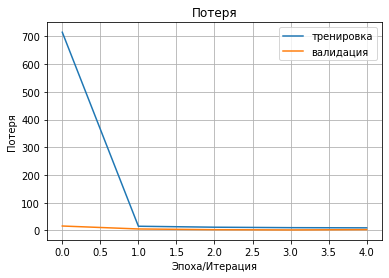

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


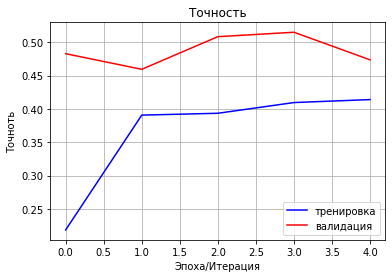

In [210]:
trajectories_rnn, train_loss, val_loss, train_accuracy, val_accuracy, opt = traning_fun(trajectories_rnn, criterion, opt, train_dl, val_dl, train_loss, val_loss, train_accuracy, val_accuracy, Discrepancy, EPOC_NUM, device, draw=True)

In [ ]:
save_checkpoint('hgv_rnn15ep5mem0+.pth', trajectories_rnn, opt)

model saved to hgv_rnn15ep5mem0+.pth


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Iteration 60 of 60 took 0.170s
    testing loss: 0.94310594
testing accuracy: 41.7 %


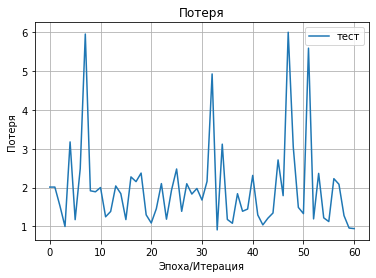

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


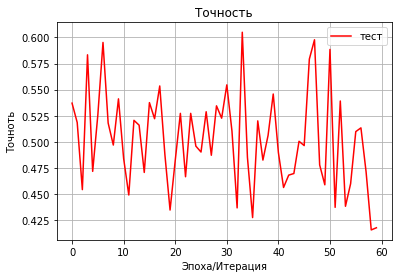

mean test loss: 1.980205
mean test accuracy: 50.2 %


In [217]:
Discrepancy = 0.05
pack_predictions, test_loss, test_accuracy = testing_fun(trajectories_rnn, criterion, test_dl, test_loss, test_accuracy, Discrepancy, device, draw=True)
print('mean test loss:', np.mean(test_loss))
print('mean test accuracy:', np.mean(test_accuracy)*1000//1/10,'%')

data_norm_factor = test_data.stats['data_norm_factor'][:]
for k in range(len(test_data.data['data'])):
    pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[:,:]*= data_norm_factor

In [76]:
def plot_trajectory(data, label=''):
    # display some trajectories for visual representation
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')
    data = np.array(data)
    colors = np.arange(data.shape[0])
    
    # Plot:
    ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], c=colors, cmap='plasma');
    ax.set_xlabel('X (10^6 m)')
    ax.set_ylabel('Y (10^6 m)')
    ax.set_zlabel('Z (10^6 m)')
    ax.set_title(CLASSNAME.get(label, label))
    
    plt.show()

Kalman

In [77]:

def predict(x, P, F, Q, B, u):
    x = F @ x + B @ u
    P = F @ P @ F.T + Q
    return x, P


def update(x, P, z, R, H, size_coordinates):
    I = np.eye(3*size_coordinates)
    y = z - H @ x
    S = H @ P @ H.T + R
    S_1 = np.linalg.inv(S)
    K = P @ H.T @ S_1
    x = x + K @ y
    P = (I - K @ H) @ P
    return x, P

In [78]:
def FilterKalman(trajectories, size_coordinates, time_step, Q_spector_noise, coordinates_noise, B = None, U = None):
    assert size_coordinates in [1, 2, 3]
    
    dt = time_step

    R = np.eye(size_coordinates) * coordinates_noise**2 #covariance matrix of measurements
    if B == None:
        B = np.zeros(size_coordinates)
    if U == None:
        u = np.zeros(size_coordinates)


    Q = np.array([[dt**5/20, dt**4/8, dt**3/6],
                  [dt**4/8,  dt**3/3, dt**2/2],
                  [dt**3/6,  dt**2/2, dt]])
    Q = Q * Q_spector_noise

    F = np.array([[1., dt, dt**2/2],
                  [0., 1., dt     ],
                  [0., 0., 1.     ]])
    
    H = np.array([1., 0., 0.])
    
    if size_coordinates==3:
        F = block_diag(F, F, F)
        Q = block_diag(Q, Q, Q)
        H = block_diag(H, H, H)
    elif size_coordinates==2:
        F = block_diag(F, F)
        Q = block_diag(Q, Q)
        H = block_diag(H, H)

    x = np.zeros(3*size_coordinates) #the initial prediction
    P = np.eye(3*size_coordinates) * 500. #confidence in the initial prediction

    trajectories_filter = []
    trajectories_filter_x = []
    trajectories_filter_P = []
    
    for id_p, point in enumerate(trajectories):
        x, P = predict(x, P, F, Q, B, u)
        x, P = update(x, P, point, R, H, size_coordinates)
        trajectories_filter.append(x[0::3])
        trajectories_filter_P.append(P[0::3,0::3]@np.ones(size_coordinates))

    return trajectories_filter, trajectories_filter_P


In [79]:
Q_spector_noise  = 500 #the density of the White noise / our trust in the filter
coordinates_noise = 50 #noise sqrt(dispersion) at the radius
size_coordinates = 3
time_step = 0.25

In [218]:
data_trajectories_filter = []
data_trajectories_filter_P = []
km_to_metr = 1000

for id_b, batch_total in enumerate(test_dl):
    batch_trajectories_filter = []
    batch_data_trajectories_filter_P = []
    for id_t, trajectories in enumerate(batch_total['data_noise'].numpy()):
        traj, traj_P = FilterKalman(trajectories * data_norm_factor * km_to_metr, size_coordinates, time_step, Q_spector_noise, coordinates_noise)
        batch_trajectories_filter.append(traj)
        batch_data_trajectories_filter_P.append(traj_P)
    data_trajectories_filter.append(np.array(batch_trajectories_filter))
    data_trajectories_filter_P.append(np.array(batch_data_trajectories_filter_P))

data_trajectories_filter=np.array(data_trajectories_filter)
data_trajectories_filter/=km_to_metr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


# Research

In [101]:
def MSE(data1, data2):
    data = data1 - data2
    data *= data
    return np.sqrt(np.sum(data)/data.size)

In [ ]:
len(test_data.data['data'])

200

In [102]:
def Deviation(data_real, data_rnn, data_kalman, Discrepancy, BATCH_SIZE_TEST, start, array_err):
    loss_rnn = []
    loss_kalman = []
    accuracy_rnn = []
    accuracy_kalman = []
    for k in range(len(data_real)):
        while k in array_err:
            k+=1

        loss_rnn.append(MSE(data_real[k][start:,:] * data_norm_factor, data_rnn[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[start:,:]))
        
        loss_kalman.append(MSE(data_real[k][start:,:] * data_norm_factor, np.array(data_kalman[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[start:,:]))
        if (len(array_err) == 0):
            if  (loss_rnn[len(loss_rnn)-1]>loss_kalman[len(loss_rnn)-1]):
                print(k)
        accuracy_rnn.append(accuracy(data_rnn[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[start:,:], data_real[k][start:,:] * data_norm_factor, Discrepancy))
        accuracy_kalman.append(accuracy(np.array(data_kalman[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[start:,:], data_real[k][start:,:] * data_norm_factor, Discrepancy))

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    plt.title('Точность фильтрации')
    plt.ylabel('точность')
    plt.xlabel('траектории')
    plt.plot(accuracy_kalman, label='Калман', color ='#1f77b4', linewidth = 2)
    plt.plot(accuracy_rnn, label='RNN', color ='#ff7f0e', linewidth = 2)
    plt.legend()
    plt.grid(True)
    fig.savefig('battleacc.eps', format='eps')
    plt.show()

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    plt.title('Потери фильтрации')
    plt.ylabel('Ошибка, км')
    plt.xlabel('траектории')
    plt.plot(loss_rnn, label='RNN', color ='#ff7f0e', linewidth = 2)
    plt.plot(loss_kalman, label='Калман', color ='#1f77b4', linewidth = 2)
    plt.legend()
    plt.grid(True)
    fig.savefig('battleloss.eps', format='eps')
    plt.show()
    
    return loss_rnn, loss_kalman, accuracy_rnn, accuracy_kalman

In [103]:
start = 10
k = 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0
1
3
4
5
6
7
8
9
10
11
13
14
16
17
18
19
21
22
23
24
26
27
28
29
30
32
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
51
53
54
55
56
57
58
59
61
62
63
64
66
67
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
88
89
90
91
92
93
94
96
97
98
99
100
101
102
103
105
106
107
108
110
111
112
114
115
116
117
118
119
120
122
123
124
125
126
127
128
129
130
131
133
134
136
137
138
139
140
141
142
143
144
146
147
148
149
150
151
152
153
154
155
156
157
158
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
179
180
182
183
184
185
186
187
188
190
192
193
194
195
196
197
198
199
200
201
203
204
205
206
207
208
210
211
212
213
214
215
216
217
218
219
220
221
223
224
226
227
228
229
230
231
232
233
234
235
236


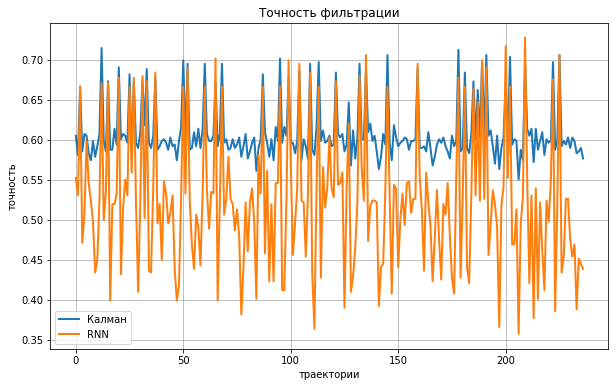

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


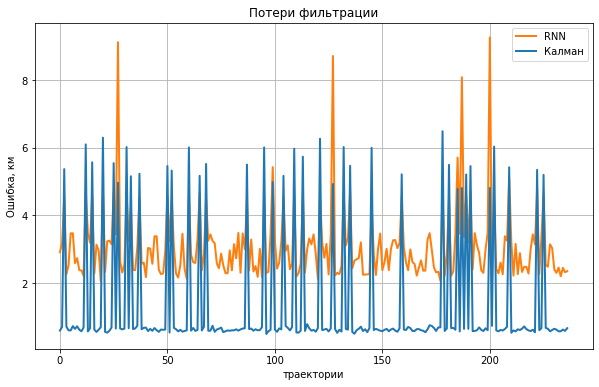

mean loss rnn 3.1068785692739898
mean loss kalman 1.3851303320712298
mean accuracy rnn 52.0 %
mean accuracy kalman 60.0 %


In [219]:
loss_rnn, loss_kalman, accuracy_rnn, accuracy_kalman = Deviation(test_data.data['data'], pack_predictions, data_trajectories_filter, Discrepancy, BATCH_SIZE_TEST, start, array_err)
print('mean loss rnn', np.mean(loss_rnn))
print('mean loss kalman', np.mean(loss_kalman))
print('mean accuracy rnn', np.mean(accuracy_rnn)*100//1,'%')
print('mean accuracy kalman', np.mean(accuracy_kalman)*100//1,'%')


In [75]:

k = 2
loss_rnn_k = []
loss_kalman_k = []
losss_measurement = []
for index in range(len(test_data.data['data'][k])-start):
    i=index+start
    loss_kalman_k.append([test_data.data['data'][k,i,0] * data_norm_factor[0] -data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][i][0],
                          test_data.data['data'][k,i,1] * data_norm_factor[1] -data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][i][1],
                          test_data.data['data'][k,i,2] * data_norm_factor[2] -data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][i][2]])
    
    loss_rnn_k.append([test_data.data['data'][k,i,0] * data_norm_factor[0] -pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[i][0],
                       test_data.data['data'][k,i,1] * data_norm_factor[1] -pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[i][1],
                       test_data.data['data'][k,i,2] * data_norm_factor[2] -pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[i][2]])
    losss_measurement.append([test_data.data['data'][k,i,0] * data_norm_factor[0]-test_data.data['data_noise'][k,i,0] * data_norm_factor[0],
                              test_data.data['data'][k,i,1] * data_norm_factor[1]-test_data.data['data_noise'][k,i,1] * data_norm_factor[1],
                              test_data.data['data'][k,i,2] * data_norm_factor[2]-test_data.data['data_noise'][k,i,2] * data_norm_factor[2]])
loss_kalman_k = np.absolute(np.array(loss_kalman_k))
loss_rnn_k = np.absolute(np.array(loss_rnn_k))
losss_measurement = np.absolute(np.array(losss_measurement))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


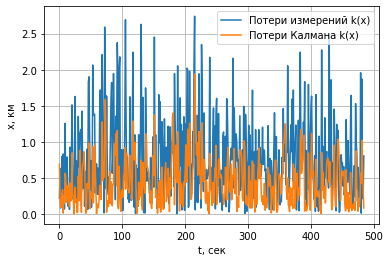

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


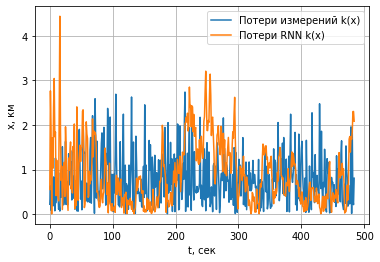

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


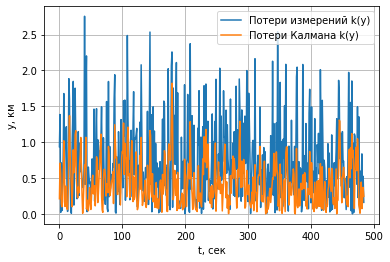

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


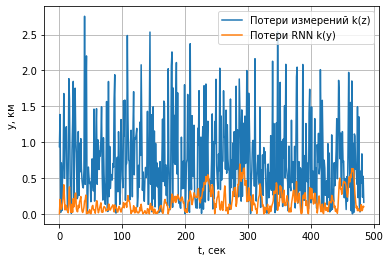

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


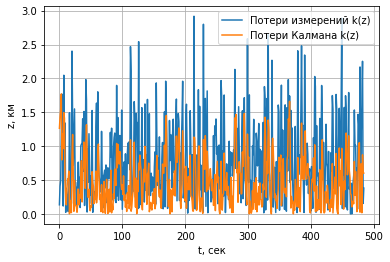

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


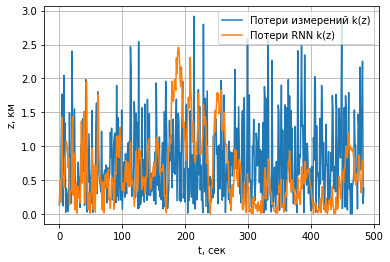

In [76]:
fig, ax = plt.subplots()
plt.ylabel('x, км')
plt.xlabel('t, сек')
plt.plot(losss_measurement[:,0], label='Потери измерений k(x)')
plt.plot(loss_kalman_k[:,0], label='Потери Калмана k(x)')
plt.legend()
plt.grid(True)
fig.savefig('kalmanx0.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
plt.ylabel('x, км')
plt.xlabel('t, сек')
plt.plot(losss_measurement[:,0], label='Потери измерений k(x)')
plt.plot(loss_rnn_k[:,0], label='Потери RNN k(x)')
plt.legend()
plt.grid(True)
fig.savefig('nnx0.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
plt.ylabel('y, км')
plt.xlabel('t, сек')
plt.plot(losss_measurement[:,1], label='Потери измерений k(y)')
plt.plot(loss_kalman_k[:,1], label='Потери Калмана k(y)')
plt.legend()
plt.grid(True)
fig.savefig('kalmany0.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
plt.ylabel('y, км')
plt.xlabel('t, сек')
plt.plot(losss_measurement[:,1], label='Потери измерений k(z)')
plt.plot(loss_rnn_k[:,1], label='Потери RNN k(y)')
plt.legend()
plt.grid(True)
fig.savefig('nny0.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
plt.ylabel('z, км')
plt.xlabel('t, сек')
plt.plot(losss_measurement[:,2], label='Потери измерений k(z)')
plt.plot(loss_kalman_k[:,2], label='Потери Калмана k(z)')
plt.legend()
plt.grid(True)
fig.savefig('kalmanz0.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
plt.ylabel('z, км')
plt.xlabel('t, сек')
plt.plot(losss_measurement[:,2], label='Потери измерений k(z)')
plt.plot(loss_rnn_k[:,2], label='Потери RNN k(z)')
plt.legend()
plt.grid(True)
fig.savefig('nnz0.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


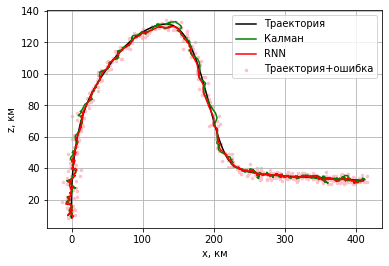

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


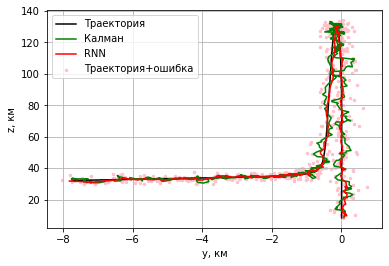

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


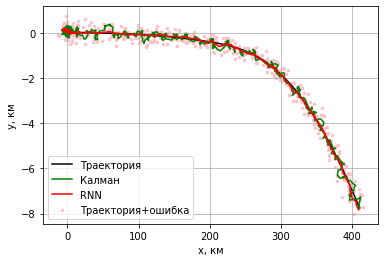

In [ ]:
a0 = start
a1 = 0
a2 = 2
fig, ax = plt.subplots()
plt.ylabel('z, км')
plt.xlabel('x, км')
plt.scatter(test_data.data['data_noise'][k][a0:,a1] * data_norm_factor[a1], test_data.data['data_noise'][k][a0:,a2] * data_norm_factor[a2], label='Траектория+ошибка', c='pink', s=6)
plt.plot(test_data.data['data'][k][a0:,a1] * data_norm_factor[a1], test_data.data['data'][k][a0:,a2] * data_norm_factor[a2], label='Траектория', color='black', linewidth = 2)
plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='Калман', color='green', linewidth = 2)
plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='RNN', color='r', linewidth = 2)
plt.legend()
plt.grid(True)
fig.add_axes(alpha=1)
fig.savefig('xz0.eps', format='eps')
plt.show()

a1 = 1
a2 = 2
fig, ax = plt.subplots()
plt.ylabel('z, км')
plt.xlabel('y, км')
plt.scatter(test_data.data['data_noise'][k][a0:,a1] * data_norm_factor[a1], test_data.data['data_noise'][k][a0:,a2] * data_norm_factor[a2], label='Траектория+ошибка', c='pink', s=6)
plt.plot(test_data.data['data'][k][a0:,a1] * data_norm_factor[a1], test_data.data['data'][k][a0:,a2] * data_norm_factor[a2], label='Траектория', color='black', linewidth = 2)
plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='Калман', color='green', linewidth = 2)
plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='RNN', color='r', linewidth = 2)
plt.legend()
plt.grid(True)
fig.savefig('yz0.eps', format='eps')
plt.show()

a1 = 0
a2 = 1
fig, ax = plt.subplots()
plt.ylabel('y, км')
plt.xlabel('x, км')
plt.scatter(test_data.data['data_noise'][k][a0:,a1] * data_norm_factor[a1], test_data.data['data_noise'][k][a0:,a2] * data_norm_factor[a2], label='Траектория+ошибка', c='pink', s=6)
plt.plot(test_data.data['data'][k][a0:,a1] * data_norm_factor[a1], test_data.data['data'][k][a0:,a2] * data_norm_factor[a2], label='Траектория', color='black', linewidth = 2)
plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='Калман', color='green', linewidth = 2)
plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='RNN', color='r', linewidth = 2)
plt.legend()
plt.grid(True)
fig.savefig('xy0.eps', format='eps')
plt.show()

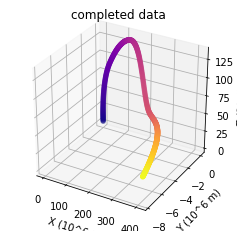

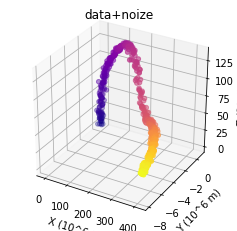

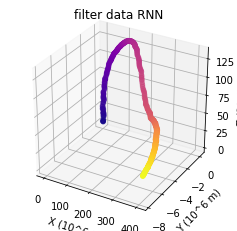

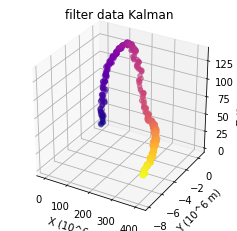

In [ ]:
plot_trajectory(test_data.data['data'][k][a0:,:] * data_norm_factor[:], 'completed data')
plot_trajectory(test_data.data['data_noise'][k][a0:,:]* data_norm_factor[:], 'data+noize')
plot_trajectory(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,:], 'filter data RNN')
plot_trajectory(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,:], 'filter data Kalman')

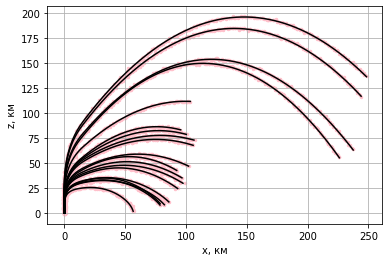

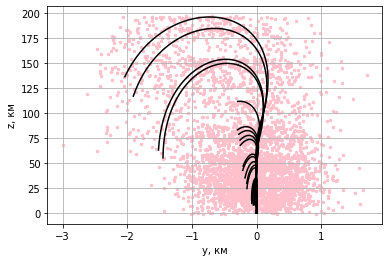

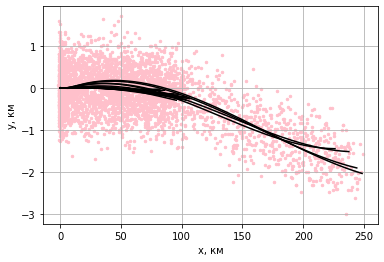

In [199]:
a0 = 0
a1 = 0
a2 = 2
fig, ax = plt.subplots()
plt.ylabel('z, км')
plt.xlabel('x, км')
for k in range(len(test_data.data['data'])//10):
  plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='траектория', color='black')
  plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='траектория+шум', c='pink', s=6)
#plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
#plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
plt.grid(True)
fig.savefig('hgv1.eps', format='eps')
plt.show()

a1 = 1
a2 = 2
fig, ax = plt.subplots()
plt.ylabel('z, км')
plt.xlabel('y, км')
for k in range(len(test_data.data['data'])//10):
  plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='траектория', color='black')
  plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='траектория+шум', c='pink', s=6)
#plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
#plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
plt.grid(True)
fig.savefig('hgv2.eps', format='eps')
plt.show()

a1 = 0
a2 = 1
fig, ax = plt.subplots()
plt.ylabel('y, км')
plt.xlabel('x, км')
for k in range(len(test_data.data['data'])//10):
  plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='траектория', color='black')
  plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='траектория+шум', c='pink', s=6)
#plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
#plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
plt.grid(True)
fig.savefig('hgv3.eps', format='eps')
plt.show()

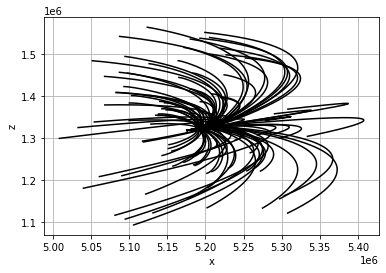

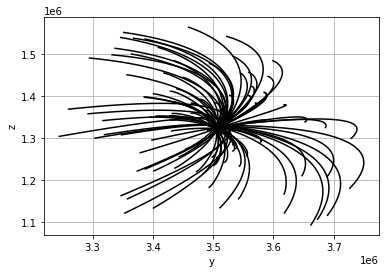

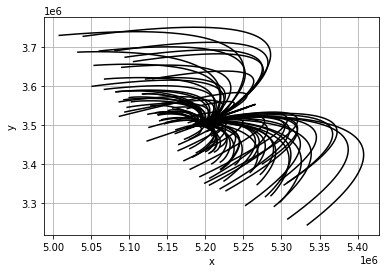

In [65]:
a0 = 3
a1 = 0
a2 = 2
plt.ylabel('z')
plt.xlabel('x')
for k in range(len(test_keys)//2):
    key_k = test_keys[k]
    plt.plot(np.array(dset[key_k])[a0:,a1], np.array(dset[key_k])[a0:,a2], label='data', color='black')
plt.grid(True)
plt.show()

a1 = 1
a2 = 2
plt.ylabel('z')
plt.xlabel('y')
for k in range(len(test_keys)//2):
    key_k = test_keys[k]
    plt.plot(np.array(dset[key_k])[a0:,a1], np.array(dset[key_k])[a0:,a2], label='data', color='black')
plt.grid(True)
plt.show()

a1 = 0
a2 = 1
plt.ylabel('y')
plt.xlabel('x')
for k in range(len(test_keys)//2):
    key_k = test_keys[k]
    plt.plot(np.array(dset[key_k])[a0:,a1], np.array(dset[key_k])[a0:,a2], label='data', color='black')
plt.grid(True)
plt.show()

In [66]:
def return_RelativeTrajectory(data_RelativeTrajectory, name = 'data'):
    columns = ['coord_x', 'coord_y', 'coord_z', 't']
    for k in range(len(data_RelativeTrajectory.data[name])):
      data_RT = data_RelativeTrajectory.data[name][k]
      if k == 0:

          data_rnn = []
          pre_id = data_RelativeTrajectory.data['traj_ids'][k]
          orig= data_RT * data_RelativeTrajectory.stats['data_norm_factor'][:]
      else:
          if data_RelativeTrajectory.data['traj_ids'][k] == pre_id:
              orig= np.append(orig, data_RT * data_RelativeTrajectory.stats['data_norm_factor'][:], axis = 0)
          else:
              pre_id = data_RelativeTrajectory.data['traj_ids'][k]
              rt = RelativeTrajectory(orig, config=data_RelativeTrajectory.configs[k])
              data_rnn.append(rt.restore(columns))
              orig = data_RT * data_RelativeTrajectory.stats['data_norm_factor'][:]
    return data_rnn


In [67]:
data_rnn = return_RelativeTrajectory(test_data, name = 'data')#'data_noise'

KeyError: ignored

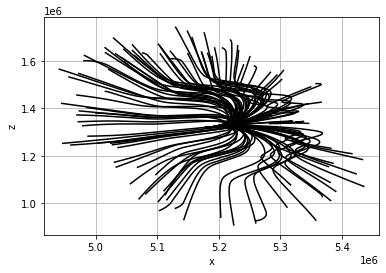

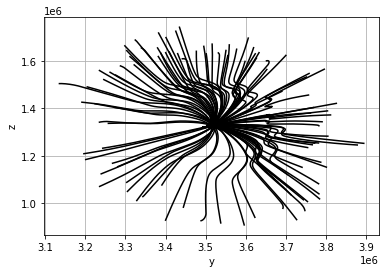

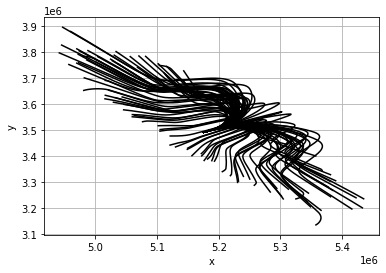

In [ ]:
a0 = 3
a1 = 0
a2 = 2
plt.ylabel('z')
plt.xlabel('x')
for k in range(len(data_rnn)//2):
  plt.plot(np.array(data_rnn[k])[a0:,a1], np.array(data_rnn[k])[a0:,a2], label='data', color='black')
plt.grid(True)
plt.show()

a1 = 1
a2 = 2
plt.ylabel('z')
plt.xlabel('y')
for k in range(len(data_rnn)//2):
  plt.plot(np.array(data_rnn[k])[a0:,a1], np.array(data_rnn[k])[a0:,a2], label='data', color='black')
plt.grid(True)
plt.show()

a1 = 0
a2 = 1
plt.ylabel('y')
plt.xlabel('x')
for k in range(len(data_rnn)//2):
  plt.plot(np.array(data_rnn[k])[a0:,a1], np.array(data_rnn[k])[a0:,a2], label='data', color='black')
plt.grid(True)
plt.show()

In [ ]:
def return_predictions(pack_predictions, data_RelativeTrajectory, BATCH_SIZE_TEST, name = 'data'):
    columns = ['coord_x', 'coord_y', 'coord_z', 't']
    for k in range(len(data_RelativeTrajectory.data[name])):
      data_RT = np.array(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])
      if k == 0:

          data_rnn = []
          pre_id = data_RelativeTrajectory.data['traj_ids'][k]
          orig= data_RT * data_RelativeTrajectory.stats['data_norm_factor'][:]
      else:
          if data_RelativeTrajectory.data['traj_ids'][k] == pre_id:
              orig= np.append(orig, data_RT * data_RelativeTrajectory.stats['data_norm_factor'][:], axis = 0)
          else:
              pre_id = data_RelativeTrajectory.data['traj_ids'][k]
              rt = RelativeTrajectory(orig, config=data_RelativeTrajectory.configs[k])
              data_rnn.append(rt.restore(columns))
              orig = data_RT * data_RelativeTrajectory.stats['data_norm_factor'][:]
    return data_rnn

In [ ]:
orig_pack_predictions = return_predictions(pack_predictions, test_data, BATCH_SIZE_TEST, 'data')

NameError: ignored